# Classifiction Methods Notebook
*Zach Jacobson -- started 11/18/2023*

In [1]:
#THIS approach (augmenting the title data across classes to be less skewed) 
# was distilled and migrated into the 'classes_and_methods' folder 
# under the file name 'title_data_augmenter_class'

#IMPORTS
import classes_and_methods.soam_class as soam #contains a text cleaning method
import pandas as pd
import numpy as np
import math
import re
from collections import Counter
from scipy.stats import entropy
import seaborn as sns #for plots
import matplotlib.pyplot as plt
#FOR HELPER METHODS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zachj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Data Load (provided by Salvatore from AstroBin site)
df = pd.read_csv("data/astrobin_titles_to_subject_types.csv") #the main starting data frame

In [3]:
#set data types
df['subject_type'] = df['subject_type'].astype('category') #subject_type is our pre-defined categories
df['title'] = df['title'].astype(str) #title is our text data

In [4]:
#data set cleaning
df = df.dropna(how='all') #droping only the rows with 'na' across ALL columns
df = df.dropna(subset=['title']) #droping only the rows with 'na' ONLY in title column
df = df[df['title'] != 'nan'] #droping only the rows with 'nan' ONLY in title column
df = df[~df['title'].str.isspace()] #droping only the rows with just '  ' (white space) as title
df = df[df['title']!=''] #droping only the rows with just '' (dead space) as title
df = df.dropna(subset=['subject_type']) #droping only the rows with 'na' subject_type                                                
#cleaning out the odd '600' category, converting it to 'OTHER' (per email "Image Title Classification | AstroBin")
df['subject_type'] = df['subject_type'].replace('600','OTHER')
#title cleaning (text cleaning method can be reviewed in the appendix, referenced in imports)
df['cleaned_title'] = df['title'].apply(soam.provided_cleaning_method)

### DATA REVIEW

In [5]:
df.describe()

,title,subject_type,solar_system_main_subject,cleaned_title
count,591317,591317,120306,591317
unique,325428,8,20,273987
top,M42,DEEP_SKY,SUN,m 42
freq,2661,444255,35076,3194


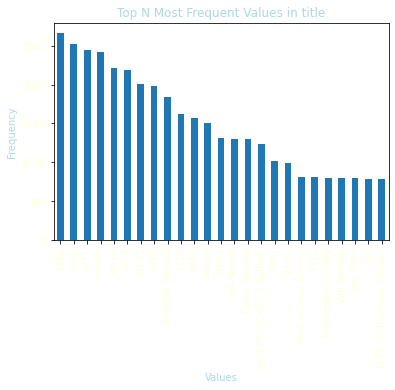

In [6]:
#... There appears to be alot of repeat titles across the data

# Get the value counts for each unique value in the title column
value_counts = df['title'].value_counts()
n = 25 # Display the top n most frequent values
top_values = value_counts.head(n)

# Plot a bar chart of the top values
top_values.plot(kind='bar')
plt.xlabel('Values',color='lightblue')
plt.ylabel('Frequency',color='lightblue')
plt.title('Top N Most Frequent Values in title',color='lightblue')

# Set the x-axis and y-axis label color to light blue
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

plt.show()

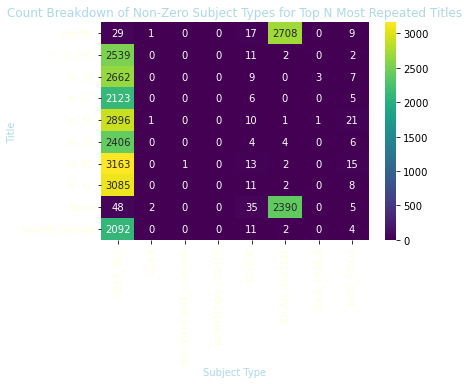

In [7]:
n = 10# Get the top n most repeated titles
top_titles = df['cleaned_title'].value_counts().nlargest(n).index

# Filter the DataFrame to include only the top titles
filtered_df = df[df['cleaned_title'].isin(top_titles)]
# Group by 'title' and 'subject_type' and count the non-zero occurrences
count_breakdown = filtered_df[filtered_df['subject_type'] != 0].groupby(['cleaned_title', 'subject_type']).size()

# Reset index to make 'title' and 'subject_type' regular columns
count_breakdown = count_breakdown.reset_index(name='count')

# Pivot the DataFrame for better presentation
pivot_df = count_breakdown.pivot_table(index='cleaned_title', columns='subject_type', values='count', fill_value=0)

# Create a heatmap
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='d')

# Set plot labels and title
plt.xlabel('Subject Type',color='lightblue')
plt.ylabel('Title',color='lightblue')
plt.title('Count Breakdown of Non-Zero Subject Types for Top N Most Repeated Titles', color='lightblue')

# Set the x-axis and y-axis label color to light yellow
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

# Show the plot
plt.show()

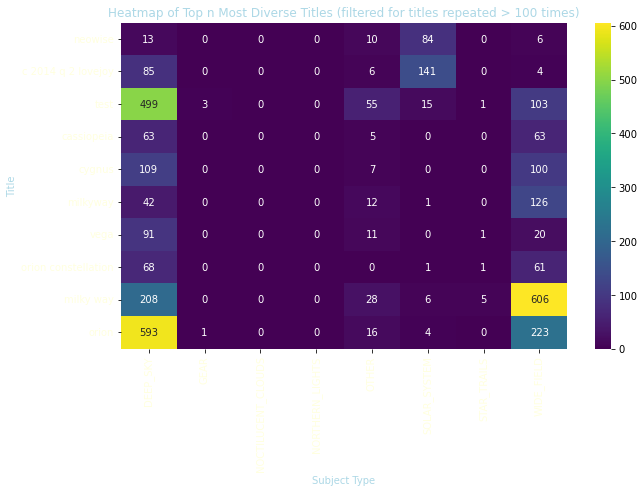

In [8]:
# ... It appears that most of the repeated titles are clearly contained within a set category
# However, I wonder if there are any problematic repeated titles...

#THIS TAKES A MINUTE...

# Filter out titles repeated 100 times or less
filtered_df = df.groupby('cleaned_title').filter(lambda x: len(x) > 100)

# Calculate entropy for each title in the filtered DataFrame
title_entropy = filtered_df.groupby('cleaned_title')['subject_type'].apply(lambda x: entropy(x.value_counts(normalize=True)))

# Sort titles based on entropy in descending order
sorted_titles = title_entropy.sort_values(ascending=False).index

n = 10 # Get the top n most diverse (entropic) titles

# Select the top n most diverse titles
top_titles = sorted_titles[:n]

# Create a pivot table to count occurrences of titles in each category
pivot_table = filtered_df.pivot_table(index='cleaned_title', columns='subject_type', aggfunc='size', fill_value=0)

# Filter the pivot table to include only the top titles
pivot_table_top = pivot_table.loc[top_titles]

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_top, cmap='viridis', annot=True, fmt='g', cbar=True)

# Set plot labels and title
plt.xlabel('Subject Type',color='lightblue')
plt.ylabel('Title',color='lightblue')
plt.title('Heatmap of Top n Most Diverse Titles (filtered for titles repeated > 100 times)',color='lightblue')

# Set the x-axis and y-axis label color to light yellow
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

plt.show()

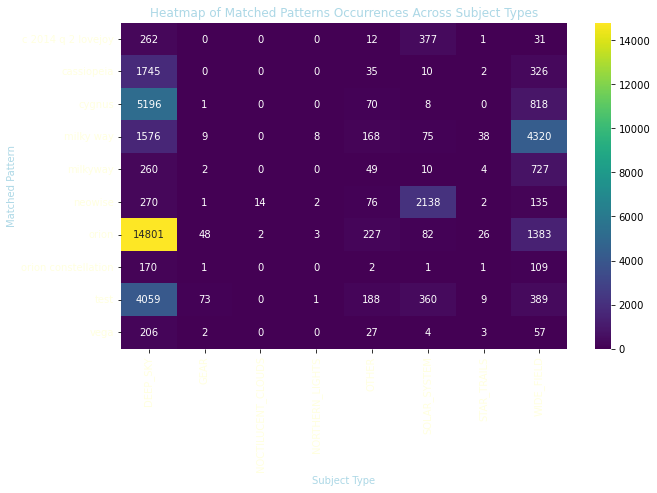

In [9]:
# ... there do appear to be some unfortunate splits across categories for some repeated titles
# I wonder if these title text are more clearly represented in a single category across all titles

pattern_regex = '|'.join(pivot_table_top.index)
matches = df['cleaned_title'].str.extractall(f'({pattern_regex})').groupby(level=0).agg(lambda x: list(x))
# Merge the matches back to the original DataFrame
extra_df = df.merge(matches, how='left', left_index=True, right_index=True)
# Rename the new column
extra_df.rename(columns={0: 'Matched_Patterns'}, inplace=True)
extra_df = extra_df[~extra_df['Matched_Patterns'].isna()]

# Explode the 'Matched_Patterns' column to create separate rows for each pattern
exploded_df = extra_df.explode('Matched_Patterns')

# Create a pivot table to count occurrences of matched patterns in each subject_type
pivot_table = exploded_df.pivot_table(index='Matched_Patterns', columns='subject_type', aggfunc='size', fill_value=0)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='g', cbar=True)
plt.title('Heatmap of Matched Patterns Occurrences Across Subject Types',color='lightblue')

plt.xlabel('Subject Type',color='lightblue')
plt.ylabel('Matched Pattern',color='lightblue')
# Set the x-axis and y-axis label color to light yellow
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

plt.show()

In [10]:
# ... so, some title words are not-so-clear-cut across the subject_types (data noise is real)
# BUT there may be important information in this noise, so lets not remove duplicates at this time
# The reason being would be the fact that each duplicated title should be assumed to be a unique
# Image upload...

#It is also important to realize that the titles listed across all categories are rather skewed

# Get the value counts and create a DataFrame
table = pd.DataFrame(df['subject_type'].value_counts()).reset_index()
# Rename the columns for clarity
table.columns = ['Subject', 'Count']
#set percentages column
total = sum(table['Count'])
table['Percentages'] = table['Count']/total


# Display the table
print("Table of subject_type Counts:")
print(table)
print(f'TOTAL = {total}')

Table of subject_type Counts:
              Subject   Count  Percentages
0            DEEP_SKY  444255     0.751298
1        SOLAR_SYSTEM  111233     0.188111
2          WIDE_FIELD   20108     0.034005
3               OTHER    9670     0.016353
4                GEAR    3587     0.006066
5         STAR_TRAILS    1628     0.002753
6     NORTHERN_LIGHTS     674     0.001140
7  NOCTILUCENT_CLOUDS     162     0.000274
TOTAL = 591317


## SUPPLEMENTAL DATA FOR AUGMENTATION

In [11]:
# GET SUPLEMENTAL EQUIPMENT DATA
# This file is a copy-paste of the https://optcorp.com/ catalog for:
# TELESCOPES
# MOUNTS
# CAMERAS
#... all pages

file_name = 'Augement_Equipment_OPT'
with open(f'data/{file_name}.txt', 'r') as file:
    # Read the file line by line and store each line in a list
    file_lines = file.readlines() 

#IGNORE HEADERS 
headers = '-------'
#Ignore short text lines
n = 18
#ignore pricing text lines
usd = '$'
# JUST EQUIPMENT text NAMES SHOULD REMAIN
equipment_text = {x for x in file_lines if (headers not in x) and (len(x)>n) and (usd not in x)}
#ignore new line characters
equipment_text = {re.sub('\n','', x) for x in equipment_text}
#equipment_text

In [12]:
# GET SUPLEMENTAL NOCTILUCENT_CLOUDS TEXT
file_name = 'Augement_NOCTILUCENT_CLOUDS_Wiki'
with open(f'data/{file_name}.txt', 'r') as file:
    # Read the file line by line and store each line in a list
    file_text = file.read() 

noctilucent_string = re.sub('[0-9]','',file_text)
#noctilucent_string

In [13]:
# GET SUPLEMENTAL NOCTILUCENT_CLOUDS DATA
#generated a variaty of NOCTILUCENT CLOUD descriptions using ChatGPT
file_name = 'Augement_NOCTILUCENT_CLOUDS_GPT'
with open(f'data/{file_name}.txt', 'r') as file:
    # Read the file line by line and store each line in a list
    file_lines = file.readlines() 

#ChatGPT NOCTILUCENT CLOUD lines
noctilucent_text = {x for x in file_lines if len(x)>1}
#ignore new line characters
noctilucent_text = {re.sub('\n','', x) for x in noctilucent_text}
#noctilucent_text

In [14]:
# GET SUPLEMENTAL NORTHERN_LIGHTS DATA
#generated a variaty of NOCTILUCENT CLOUD descriptions using ChatGPT
file_name = 'Augement_NORTHERN_LIGHTS_GPT'
with open(f'data/{file_name}.txt', 'r') as file:
    # Read the file line by line and store each line in a list
    file_lines = file.readlines() 

#ChatGPT NOCTILUCENT CLOUD lines
northernlights_text = {x for x in file_lines if len(x)>1}
#ignore new line characters
northernlights_text = {re.sub('\n','', x) for x in northernlights_text}
#northernlights_text

## HELPER METHODS

In [15]:
#HELPER METHODS
def smooth_towards_center(numbers, smoothing_factor):
    """
    TAKES:
    a list of numbers
    smoothing_factor of 0-1 (0 being no smoothing)
    RETURNS a list of smoothed_numbers
    """
    smoothed_numbers = []
    central_value = sum(numbers) / len(numbers)
    for number in numbers:
        # Calculate a weighted average
        smoothed_value = round(smoothing_factor * central_value + (1 - smoothing_factor) * number)
        smoothed_numbers.append(smoothed_value)

    return smoothed_numbers

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(text, iterations=1):
    #print(f'----{text}')# ------- TESTING
    words = text.split()
    augmented_text = words.copy()
    # Iterate 'n' times to perform synonym replacement
    for _ in range(iterations):
        # Choose a random index to replace a word with a synonym
        word_index = random.randint(0, len(words) - 1)
        # Get a list of synonyms for the selected word
        synonym_list = get_synonyms(words[word_index])
        # If synonyms are available, choose one randomly and replace the original word
        if synonym_list:
            synonym = random.choice(synonym_list)
            augmented_text[word_index] = synonym
    #return synonym replaced string
    return ' '.join(augmented_text)

def random_split(input_string, n):
    #print(f'{n}: {input_string}') #--- TESTING
    # Get indices of whitespace in the input string
    whitespace_indices = [i for i, char in enumerate(input_string) if char.isspace()]
    # Choose n-1 random indices from the whitespace positions
    split_indices = random.sample(whitespace_indices, n-1) + [len(input_string)]
    # Sort the split indices for consistency
    split_indices.sort()
    # Initialize variables to keep track of split portions
    split_parts = []
    prev_index = 0
    # Iterate over split indices
    for index in split_indices:
        split_parts.append(input_string[prev_index:index].strip())
        prev_index = index
    return split_parts

def splicer(str1, str2):
    """
    Takes two strings makes n number of cuts to each
    make (the wrong) assumption that all portions are equal in size 
    randomly select portions from each str until you get a "whole"
    returns the spliced result of the selected portions
    """
    n_cuts = math.floor(min(str1.count(' '),str2.count(' '))/2)
    n_portions = n_cuts+1 #... if you cut twice you get three portions
    #portion out the string
    #print(f'STRINGS 1:{str1} ----- 2:{str2}')#--- TESTING
    if n_cuts>0:
        portions1 = random_split(str1,n_portions)
        portions2 = random_split(str2,n_portions)
    else:
        portions1 = [str1]
        portions2 = [str2]
    #...and shuffle the portions
    random.shuffle(portions1)
    random.shuffle(portions2)
    #return spliced string
    spliced_str = ""
    for i in range(0,n_portions):
        if(i%2==0): #all even numbered iterations take from str1
            spliced_str = spliced_str +" "+ portions1[i]
        else: #all uneven numbered iteration take from str2
            spliced_str = spliced_str +" "+ portions2[i]
    return(spliced_str.strip())

def portion_sampler(s, portion_size = 5, sample_size = 1):
    # Split the text into words
    words = s.split()
    # Ensure n is a valid size
    if portion_size <= 0 or portion_size > len(words):
        return []
    # Generate and return the sampled portions
    portions = [' '.join(words[i:i+portion_size]) for i in range(len(words) - portion_size + 1)]
    sampled_portions = random.sample(portions,sample_size)
    return sampled_portions

#requires from nltk.corpus import stopwords AND import classes_and_methods.soam_class as soam #contains a text cleaning method
english_stopwords = stopwords.words('english')
def clean_and_remove_stops(strings, english_stopwords = english_stopwords, cleaning_method = soam.provided_cleaning_method):
    #clean strings in a standard way
    strings = [cleaning_method(s) for s in strings]
    #split strings into tokens 
    tokenized_strings = [s.split() for s in strings]
    # Remove stop words from each list of words
    filtered_strings = [
        ' '.join([w for w in words if w not in english_stopwords]) for words in tokenized_strings
    ]
    return filtered_strings#english_stopwords

In [16]:
# Get the value counts and create a DataFrame
table = pd.DataFrame(df['subject_type'].value_counts()).reset_index()
# Rename the columns for clarity
table.columns = ['Subject', 'Count']

print(table)
print()

table['Smoothed_Count'] = smooth_towards_center(table['Count'],0.4)
print(table)
print(int(table[table['Subject']=="WIDE_FIELD"]['Smoothed_Count']))

              Subject   Count
0            DEEP_SKY  444255
1        SOLAR_SYSTEM  111233
2          WIDE_FIELD   20108
3               OTHER    9670
4                GEAR    3587
5         STAR_TRAILS    1628
6     NORTHERN_LIGHTS     674
7  NOCTILUCENT_CLOUDS     162

              Subject   Count  Smoothed_Count
0            DEEP_SKY  444255          296119
1        SOLAR_SYSTEM  111233           96306
2          WIDE_FIELD   20108           41631
3               OTHER    9670           35368
4                GEAR    3587           31718
5         STAR_TRAILS    1628           30543
6     NORTHERN_LIGHTS     674           29970
7  NOCTILUCENT_CLOUDS     162           29663
41631


In [17]:
def title_data_augmenter(df, counts_table, smoothing_factor, supplement_params,verbose = False):
    """
    Where:
        df holds the un-augmented source data
        counts_table has a 'Subject' col that matches 'subject_types' in df col
        counts_table has a 'Count' col that holds the aggregated count of each corresponding 'Subject'
        smoothing factor is a float 0-1 (0 is no smoothing)
        supplement_params is a dict with 'subject_types' keys holding settings and data for:
            ['supplement_list'] #... this is a list or False
            ['supplement_str'] #... this is a string or False
            ['supplement_synonyms'] #... this is True or False
    """
    #Get Augmented Data Set
    augmented_data = {
        'title':[],
        'subject_type':[],
        'augmentation':[]
    }
    #get smoothed table counts
    counts_table['Smoothed_Count'] = smooth_towards_center(counts_table['Count'],smoothing_factor)
    
    for category in supplement_params:
        #print(f' ----------- {category}') # ------ TESTING
        #collect the astrobin category data
        source_data = list(df[df['subject_type']==category]['cleaned_title'])
        #print(f'   source_data length = {len(source_data)} -- ')  # ------ TESTING

        #randomly trim data down to n if title count exceeds n
        n = int(counts_table[counts_table['Subject']==category]['Smoothed_Count'])
        if len(source_data)> n: 
            augment_titles = random.sample(source_data,n) #...this is the trim
            augmented_data['title'] = augmented_data['title']+augment_titles
            augmented_data['subject_type'] = augmented_data['subject_type']+[category]*n
            augmented_data['augmentation'] = augmented_data['augmentation']+['sampled']*n
            # ------ TESTING
            #print(f'     {n} titles sampled, {len(source_data)-len(augment_titles)} titles trimmed away, not used.')
            #--------------
        else: #... otherwise, evenly distribute augmentations into the augmented_data based on set params
            #determine how many augmentations are needed to get up to n titles in the given category
            total_n_needed = n - len(source_data)
            #unpack the supplement data
            supplement_list = supplement_params[category]['supplement_list'] #... this is a list or False
            supplement_str = supplement_params[category]['supplement_str'] #... this is a string or False
            supplement_synonyms = supplement_params[category]['supplement_synonyms'] #... this is True or False
            #diversify augmentations across supplemental data option equally
            augmentation_parts = 1 #... we will use n number of augmentation parts
            #DETERMINE n augmentation parts
            if supplement_list: #given a list of strings
                if supplement_str: #... and a long descriptive string
                    #... add an augment portion for blending spliced list strings with descriptive string w/ source data
                    augmentation_parts = augmentation_parts + 1
                # add  augment portion for blending spliced source data with list strings
                augmentation_parts = augmentation_parts + 1
            if supplement_str and not supplement_list: #given only a long descriptive string...
                #... add an augment portion for blending spliced descriptive string portions w/ source data
                augmentation_parts = augmentation_parts + 1
            if supplement_synonyms: # are allowed...
                # add  augment portion for blending some synonyms into a portion of all supplement and source data
                augmentation_parts = augmentation_parts + 1

            augmentation_n = round(total_n_needed / augmentation_parts)
            total_n_needed = augmentation_n*augmentation_parts
            
            #GET starting population
            ###### SOURCE SAMPLED PORTION ##########################
            augmented_data['title'] = augmented_data['title']+source_data
            augmented_data['subject_type'] = augmented_data['subject_type']+[category]*len(source_data)
            augmented_data['augmentation'] = augmented_data['augmentation']+['sampled']*len(source_data)
            ###### SOURCE RESAMPLED PORTION ########################
            #ALWAYS re-sample a straight portion of the source data 
            all_resamples = random.choices(source_data,k=total_n_needed)
            #pop off the resample portion needed for this augmntation...
            resample_portions = [all_resamples.pop() for _ in range(augmentation_n)]
            augmented_data['title'] = augmented_data['title']+resample_portions
            augmented_data['subject_type'] = augmented_data['subject_type']+[category]*len(resample_portions)
            augmented_data['augmentation'] = augmented_data['augmentation']+['resampled']*len(resample_portions)
            #then SET augmentation parts ... as needed
            if supplement_list: #given a list of strings
                if supplement_str: #... and a long descriptive string
                    ########## WIKI - CHATGPT BLEND PORTION ########
                    #... add an augment portion for blending spliced list strings with descriptive string w/ source data
                    str_portions = [portion_sampler(supplement_str)[0] for _ in range(augmentation_n)]
                    list_portions = random.choices(supplement_list, k=augmentation_n)
                    blended_portions = [splicer(list_portions[i],str_portions[i]) 
                                        for i in range(augmentation_n)]
                    #pop off the resample portion needed for this augmntation...
                    resample_portions = [all_resamples.pop() for _ in range(augmentation_n)]
                    spliced_portions = [splicer(resample_portions[i],blended_portions[i]) 
                                        for i in range(augmentation_n)]
                    augmented_data['title'] = augmented_data['title']+spliced_portions
                    augmented_data['subject_type'] = augmented_data['subject_type']+[category]*len(spliced_portions)
                    augmented_data['augmentation'] = augmented_data['augmentation']+['wiki_chatgpt']*len(spliced_portions)
                ######## CHATGPT PORTION ###########################
                # add  augment portion for blending spliced source data with list strings
                # ------ TESTING
                #print(f'n = {n} -- datalength = {len(source_data)} -- augportion = {augmentation_n}')
                #--------------
                resample_portions = [all_resamples.pop() for _ in range(augmentation_n)]
                list_portions = random.choices(supplement_list, k=augmentation_n)
                spliced_portions = [splicer(resample_portions[i],list_portions[i]) 
                                    for i in range(augmentation_n)]
                augmented_data['title'] = augmented_data['title']+spliced_portions
                augmented_data['subject_type'] = augmented_data['subject_type']+[category]*len(spliced_portions)
                augmented_data['augmentation'] = augmented_data['augmentation']+['chatgpt']*len(spliced_portions)
            ######## WIKI ONLY PORTION ###########################
            if supplement_str and not supplement_list: #given only a long descriptive string...
                #... add an augment portion for blending spliced descriptive string portions w/ source data
                #... add an augment portion for blending spliced list strings with descriptive string w/ source data
                str_portions = [portion_sampler(supplement_str)[0] for _ in range(augmentation_n)]
                #pop off the resample portion needed for this augmntation...
                resample_portions = [all_resamples.pop() for _ in range(augmentation_n)]
                spliced_portions = [splicer(resample_portions[i],str_portions[i]) 
                                    for i in range(augmentation_n)]
                augmented_data['title'] = augmented_data['title']+spliced_portions
                augmented_data['subject_type'] = augmented_data['subject_type']+[category]*len(spliced_portions)
                augmented_data['augmentation'] = augmented_data['augmentation']+['wiki']*len(spliced_portions)
            ######## SYNONYM SWAP PORTION ###########################
            if supplement_synonyms: # if allowed...
                # add  augment portion for blending some synonyms into a portion of all supplement and source data
                synonym_swaps = [synonym_replacement(s) for s in source_data if len(s)>=1]
                synonym_augments = random.choices(synonym_swaps, k = augmentation_n)

                augmented_data['title'] = augmented_data['title']+synonym_augments
                augmented_data['subject_type'] = augmented_data['subject_type']+[category]*len(synonym_augments)
                augmented_data['augmentation'] = augmented_data['augmentation']+['synonym_swap']*len(synonym_augments)
            # ------ TESTING
            #print(f'     {len(source_data)} available, {total_n_needed} needed to reach {len(source_data)+total_n_needed}')
            # --------------
    df_augmented = pd.DataFrame(augmented_data)
    df_augmented['subject_type'] = df_augmented['subject_type'].astype('category')
    df_augmented['augmentation'] = df_augmented['augmentation'].astype('category')
    #df_augmented['data_type'] = []
    #print(df_augmented.describe())# ------ TESTING
    #print(df_augmented.info())# ------ TESTING
    #print(pd.DataFrame(df_augmented['subject_type'].value_counts()).reset_index())# ------ TESTING
    return(df_augmented)


# TRAINING DATA
### Data Skew Approach
To address skew of the data across subect_types, I propose the following:


In [18]:
#FIRST clean up all suplemental data prior to augmentations
english_stopwords = stopwords.words('english') #a list of all english stop words...
equipment_text = clean_and_remove_stops(equipment_text, english_stopwords)
northernlights_text = clean_and_remove_stops(northernlights_text, english_stopwords)
noctilucent_string = clean_and_remove_stops([noctilucent_string], english_stopwords)[0]
noctilucent_text = clean_and_remove_stops(noctilucent_text, english_stopwords)

In [19]:
#Arbitrarily set target data counts in each category to n titles
# -- randomly sample n from each category that contains greater than n titles
# -- pull all titles from categories less than n and suplement the rest
# -- Set up parameters for each category in how you want them handeled

#clean up all suplemental text data and remove those stop word

#params are the following options:
# supplement_str // this a single large string that portions can be sampled from
# supplement_list // this is a list of stings that can be sampled from for various augmentations
# supplement_synonyms // if true, this will allow synonym replacement augments in data
supplement_params = {
    'DEEP_SKY': {
        'supplement_str':False,
        'supplement_list':False,
        'supplement_synonyms':False},
    'SOLAR_SYSTEM': {
        'supplement_str':False,
        'supplement_list':False,
        'supplement_synonyms':False},
    'WIDE_FIELD': {
        'supplement_str':False,
        'supplement_list':False,
        'supplement_synonyms':False},
    'OTHER': {
        'supplement_str':False,
        'supplement_list':False,
        'supplement_synonyms':False},
    'GEAR': {
        'supplement_str':False,
        'supplement_list':equipment_text,
        'supplement_synonyms':False},
    'STAR_TRAILS': {
        'supplement_str':False,
        'supplement_list':False,
        'supplement_synonyms':True},
    'NORTHERN_LIGHTS': {
        'supplement_str':False,
        'supplement_list':northernlights_text,
        'supplement_synonyms':True},
    'NOCTILUCENT_CLOUDS': {
        'supplement_str':noctilucent_string,
        'supplement_list':noctilucent_text,
        'supplement_synonyms':True},
}

## A CLOSER LOOK AT THE AUGMENTED DATA

In [20]:
df_augmented = title_data_augmenter(df, table, 0.4, supplement_params)

In [21]:
categories_to_match = ['sampled']
df_augmented['original_data'] = df_augmented['augmentation'].isin(categories_to_match)
df_augmented
pd.crosstab(df_augmented['subject_type'], df_augmented['original_data'])

original_data,False,True
subject_type,,
DEEP_SKY,0,296119
GEAR,28132,3587
NOCTILUCENT_CLOUDS,29500,162
NORTHERN_LIGHTS,29295,674
OTHER,25698,9670
SOLAR_SYSTEM,0,96306
STAR_TRAILS,28916,1628
WIDE_FIELD,21523,20108


In [22]:
# Get the value counts and create a DataFrame
table = pd.DataFrame(df_augmented['subject_type'].value_counts()).reset_index()
# Rename the columns for clarity
table.columns = ['Subject', 'Count']
#set percentages column
total = sum(table['Count'])
table['Percentages'] = table['Count']/total


# Display the table
print("Table of subject_type Counts:")
print(table)
print(f'TOTAL = {total}')

Table of subject_type Counts:
              Subject   Count  Percentages
0            DEEP_SKY  296119     0.500778
1        SOLAR_SYSTEM   96306     0.162867
2          WIDE_FIELD   41631     0.070404
3               OTHER   35368     0.059812
4                GEAR   31719     0.053641
5         STAR_TRAILS   30544     0.051654
6     NORTHERN_LIGHTS   29969     0.050682
7  NOCTILUCENT_CLOUDS   29662     0.050163
TOTAL = 591318


In [23]:
pd.crosstab(df_augmented['subject_type'], df_augmented['augmentation'])

augmentation,chatgpt,resampled,sampled,synonym_swap,wiki_chatgpt
subject_type,,,,,
DEEP_SKY,0,0,296119,0,0
GEAR,14066,14066,3587,0,0
NOCTILUCENT_CLOUDS,7375,7375,162,7375,7375
NORTHERN_LIGHTS,9765,9765,674,9765,0
OTHER,0,25698,9670,0,0
SOLAR_SYSTEM,0,0,96306,0,0
STAR_TRAILS,0,14458,1628,14458,0
WIDE_FIELD,0,21523,20108,0,0


In [24]:
import pandas as pd

# Sample DataFrame
data = {'Subject': ['A', 'B', 'A', 'B', 'A', 'A', 'B', 'A', 'B'],
        'Augmentation': ['X', 'Y', 'X', 'Y', 'X', 'Y', 'Y', 'X', 'Y']}
dft = pd.DataFrame(data)

# Create a contingency table using crosstab
contingency_table = pd.crosstab(dft['Subject'], dft['Augmentation'])

# Create a new DataFrame with the counts
counts_df = pd.DataFrame(contingency_table)

# Display the new DataFrame
print(counts_df)


Augmentation  X  Y
Subject           
A             4  1
B             0  4


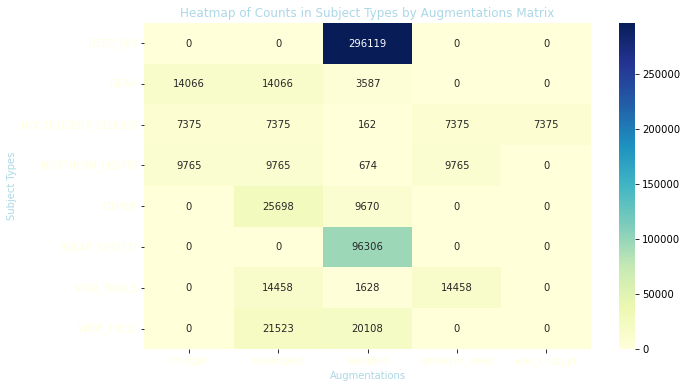

In [25]:
# Create a contingency table using crosstab
contingency_table = pd.crosstab(df_augmented['subject_type'], df_augmented['augmentation'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title('Heatmap of Counts in Subject Types by Augmentations Matrix',color='lightblue')
plt.xlabel('Augmentations',color='lightblue')
plt.ylabel('Subject Types',color='lightblue')
# Set the x-axis and y-axis label color to light blue
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')
plt.show()

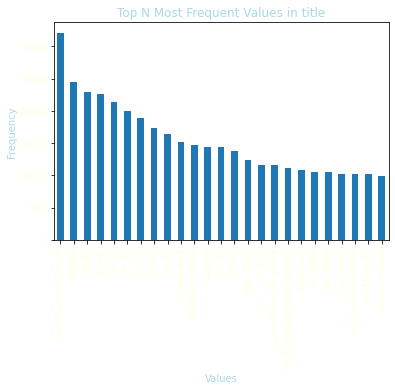

In [26]:
# Get the value counts for each unique value in the title column
value_counts = df_augmented['title'].value_counts()
n = 25 # Display the top n most frequent values
top_values = value_counts.head(n)

# Plot a bar chart of the top values
top_values.plot(kind='bar')
plt.xlabel('Values',color='lightblue')
plt.ylabel('Frequency',color='lightblue')
plt.title('Top N Most Frequent Values in title',color='lightblue')

# Set the x-axis and y-axis label color to light blue
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

plt.show()

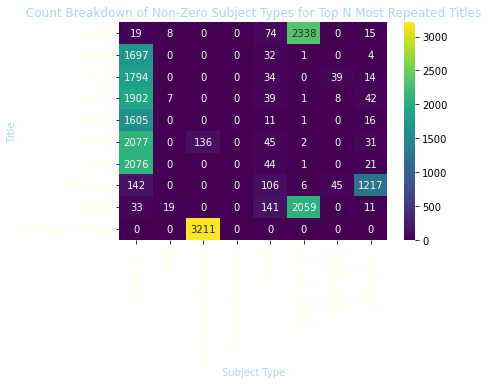

In [27]:
n = 10# Get the top n most repeated titles
top_titles = df_augmented['title'].value_counts().nlargest(n).index

# Filter the DataFrame to include only the top titles
filtered_df = df_augmented[df_augmented['title'].isin(top_titles)]
# Group by 'title' and 'subject_type' and count the non-zero occurrences
count_breakdown = filtered_df[filtered_df['subject_type'] != 0].groupby(['title', 'subject_type']).size()

# Reset index to make 'title' and 'subject_type' regular columns
count_breakdown = count_breakdown.reset_index(name='count')

# Pivot the DataFrame for better presentation
pivot_df = count_breakdown.pivot_table(index='title', columns='subject_type', values='count', fill_value=0)

# Create a heatmap
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='d')

# Set plot labels and title
plt.xlabel('Subject Type',color='lightblue')
plt.ylabel('Title',color='lightblue')
plt.title('Count Breakdown of Non-Zero Subject Types for Top N Most Repeated Titles', color='lightblue')

# Set the x-axis and y-axis label color to light yellow
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

# Show the plot
plt.show()

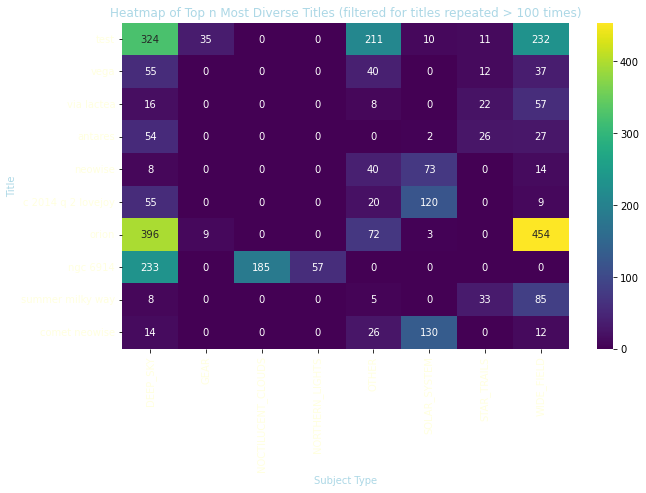

In [28]:
# ... It appears that most of the repeated titles are clearly contained within a set category
# However, I wonder if there are any problematic repeated titles...

#THIS TAKES A MINUTE...

# Filter out titles repeated 100 times or less
filtered_df = df_augmented.groupby('title').filter(lambda x: len(x) > 100)

# Calculate entropy for each title in the filtered DataFrame
title_entropy = filtered_df.groupby('title')['subject_type'].apply(lambda x: entropy(x.value_counts(normalize=True)))

# Sort titles based on entropy in descending order
sorted_titles = title_entropy.sort_values(ascending=False).index

n = 10 # Get the top n most diverse (entropic) titles

# Select the top n most diverse titles
top_titles = sorted_titles[:n]

# Create a pivot table to count occurrences of titles in each category
pivot_table = filtered_df.pivot_table(index='title', columns='subject_type', aggfunc='size', fill_value=0)

# Filter the pivot table to include only the top titles
pivot_table_top = pivot_table.loc[top_titles]

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_top, cmap='viridis', annot=True, fmt='g', cbar=True)

# Set plot labels and title
plt.xlabel('Subject Type',color='lightblue')
plt.ylabel('Title',color='lightblue')
plt.title('Heatmap of Top n Most Diverse Titles (filtered for titles repeated > 100 times)',color='lightblue')

# Set the x-axis and y-axis label color to light yellow
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

plt.show()

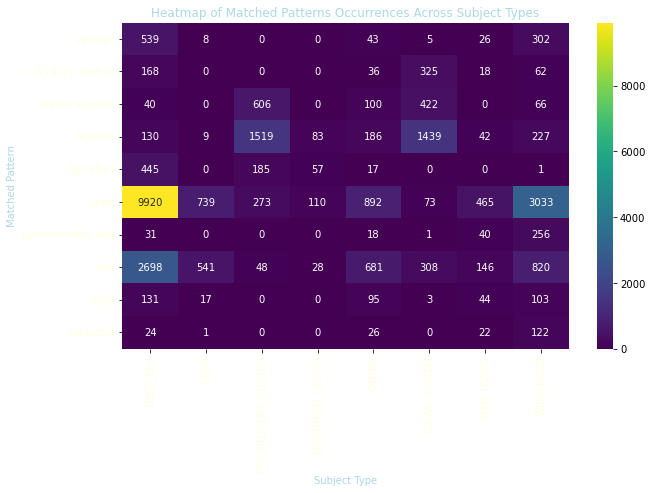

In [29]:
# ... there do appear to be some unfortunate splits across categories for some repeated titles
# I wonder if these title text are more clearly represented in a single category across all titles

pattern_regex = '|'.join(pivot_table_top.index)
matches = df_augmented['title'].str.extractall(f'({pattern_regex})').groupby(level=0).agg(lambda x: list(x))
# Merge the matches back to the original DataFrame
extra_df = df_augmented.merge(matches, how='left', left_index=True, right_index=True)
# Rename the new column
extra_df.rename(columns={0: 'Matched_Patterns'}, inplace=True)
extra_df = extra_df[~extra_df['Matched_Patterns'].isna()]

# Explode the 'Matched_Patterns' column to create separate rows for each pattern
exploded_df = extra_df.explode('Matched_Patterns')

# Create a pivot table to count occurrences of matched patterns in each subject_type
pivot_table = exploded_df.pivot_table(index='Matched_Patterns', columns='subject_type', aggfunc='size', fill_value=0)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='g', cbar=True)
plt.title('Heatmap of Matched Patterns Occurrences Across Subject Types',color='lightblue')

plt.xlabel('Subject Type',color='lightblue')
plt.ylabel('Matched Pattern',color='lightblue')
# Set the x-axis and y-axis label color to light yellow
plt.gca().tick_params(axis='x', labelcolor='lightyellow')
plt.gca().tick_params(axis='y', labelcolor='lightyellow')

plt.show()

In [35]:
#TESTING
[print(x) for x in df_augmented[df_augmented['subject_type']=='NOCTILUCENT_CLOUDS']['title']]

noctilucent clouds
noctilucent clouds
noctilucent clouds nlc 03 07 2023
inside the noctiluscent clouds
black power
seagull nebula widefield
dolphin head sh 2 308
polar stratospheric clouds
noctilucent clouds 2021 07 02 lviv ukraine
noctilucent clouds with time lapse video
widefield witchhead nebula
edit not a noctilucent cloud at 34000 ft
nlc in der göhrde
星空調色盤
noctilucent clouds
la méduse et les environs ic 443
ngc 6914
the moon with noctilucent clouds
nlcs from 01 07 2022
a small circumzenithal arc on the tyrrhenian sea created by our star
noctilucent clouds
nlc panorama würzburg rottendorf
noctilucent clouds nlc 05 07 2022
noctilucent clouds nlc 05 07 2022
nlcs into dawn as of 2022 07 05 400 mm
c 27 crescent nebula
noctilucent clouds nlc over warsaw 28 06 21
coucher de soleil sous un orage cévenol menaçant
fighting dragons of ara nebula
m 42 la nébuleuse d' orion
m 42
orion with samyang 12 mm f 2 0
nlc neowise
noctilucent clouds over the columbia basin
noctilucent cloud
noctilucent

noctilucent clouds nlc 28 06 2021
noctilucent clouds 22 6 2020
c 2020 f 3 neowise noctilucent clouds
comet c 2020 f 3 noctilucent clouds venus
noctilucent clouds
noctilucent clouds the netherlands
noctilucent clouds
noctilucent clouds iceland
noctilucent clouds
m 42
noctilucent clouds over belgium
noctilucent clouds nlc 03 07 2023
noctilucent clouds from belgium
ncls noctilucent cloud
星空調色盤
noctilucent clouds panorama
edit not a noctilucent cloud at 34000 ft
noctilucent clouds over loch leven
ncls noctilucent cloud
noctilucent clouds over loch leven
noctilucent clouds nlc
c 2020 f 3 neowise noctilucent clouds wide field
noctilucent cloud panorama over oid barns on june 19 2019
星空調色盤
c 2020 f 3 neowise noctilucent clouds
noctilucent clouds nlc
m 42
noctilucent clouds the netherlands
noctilucent clouds over fanø denmark june 21 st 2019
noctilucent clouds
nlc clouds
noctilucent cloud
equinox noctilucent dawn
menkalinan with noctilucent clouds into dawn
noctilucent clouds above patato fiel

noctilucent clouds dance summer skies
2020 atmosphere manifest noctilucent noctilucent
noctilucent clouds over climate
iceland like phenomena night shining clouds
noctilucent clouds
area showcases noctilucent clouds nlc 2020 clouds turning 07 05
polar shining clouds
noctilucent clouds nature's masterpiece unfolds noctilucent clouds weaving
dolphin dance nocturnal 308
noctilucent cloud clouds emerge
noctilucent clouds
major watching noctilucent clouds astronomical weaving some nlcs
22 6 ice otherworldly brilliance 2020
07 2021 touch clouds nlc 04
noctilucent cloud beckon sky and visible ethereal
impression capturing
06 21 2019 silver blue cosmic beauty clouds nlc
comet neowise wonder quietude polar nights of noctilucent tapestry
clouds crystals noctilucent
16 captivating observers celestial beauty atmospheric noctilucent 06 2020
04 07 2021 touch clouds nlc
neowise in the called turning c 2020 f polar heavens
noctilucent clouds over ice shadow high clouds crystals
clouds nlc atmospheric 

noctilucent clouds
nlc clouds
ukraine crystals dance nocturnal
noctilucent clouds
clouds nlc 05 celestial noctilucent
noctilucent clouds create breathtaking with time lapse video
c 2020 f 3 realms earth clouds neowise behind
neowise with faint clouds viewed glow
cloud at nights 34000 ft cosmic showcases
nlc 08 sky shining 07 2020
nlc gracefully pirouette additional water noctilucent
noctilucent whisper tales mesospheric realms molecules darkness noctilucent
noctilucent clouds reveal months latitudes noctilucent clouds' ethereal
noctilucent clouds
leven light increased science noctilucent clouds over
noctilucent noctilucent clouds grace polar
clouds iceland climate
clouds from unveil cosmic 31 2020 secrets
milano daylight visible observing noctilucent
2019 often observed night noctilucent clouds shining clouds mark
dolphin subject ongoing sh 2 308
sous un orage noctilucent clouds cévenol menaçant wonder
noctilucent clouds night prestwich manchester uk
dawn celestial ballet with noctiluc

clouds night shining clouds offer cosmic spectacle linking
noctilucent noctilucent clouds like
28 06 21 showcase otherworldly brilliance noctilucent clouds nlc
river elegance in turning
clouds nlc 05 ice crystals form celestial dance creating nocturnal poetry silver 07 2020
2 shining wonders 2020
clouds celestial ballets unfold noctilucent
06 polar heavens noctilucent cloud nlc above poland ethereal
noctilucent clouds
06 2020 crystals create night shining nlc 26
noctilucent clouds
noctilucent clouds radiant displays night shining clouds june
noctilucent tales creating luminous clouds
noctilucent clouds skies 12 07 2019
noctilucent clouds
nlc noctilucent clouds paint night celestial enchantment 16 06 2020
black power
clouds nlc clouds reveal cosmic secrets
brunstfield arctic summer nights become canvas noctilucent clouds painting night celestial
small circumzenithal arc on sky a arctic star clouds adding mystery
2020 touch clouds 22 6
noctilucent clouds
close noctilucent noctilucent clo

16 2019 choreograph celestial june
noctilucent clouds nlc composite arctic horizons host noctilucent and
panorama over oid creating enchanting celestial 2019 night shining clouds 19
noctilucent clouds
noctilucent clouds nlc spectacle etching cosmic tales dark horizons 16 06
noctilucent clouds blue tapestry night
noctilucent celestial whispers unfold noctilucent
noctilucent nocturnal observers clouds june
07 2023 beauty 03
reflection in a river rare opportunity witness dynamic a interactions
noctilucent clouds
clouds 2016 illuminates night sky ethereal glow
clouds nlc canvas noctilucent clouds painting noctilucent
basin celestial ballet motion noctilucent clouds over
clouds over rheinau light
in noctilucent clouds celestial realms comet neowise c luminous displays noctilucent clouds weave silver blue
in lviv summer nights
05 07 2020 mesosphere silent beauty noctilucent
noctilucent luminous displays grace arctic night sky
seagull darkness night
from milano spectacle paint night sky lumin

first noctilucent clouds nlc 20 06 2017
noctilucent clouds with comet neowise
noctilucent overcast nlc 05 07 2022
noctilucent fog
noctilucent clouds nlc 28 06 2021
c 2020 f 3 neowise with noctilucent clouds
noctilucent clouds at fewston
noctilucent clouds with comet neowise
comet c 2020 f 3 neowise and noctilucent corrupt f 85 mm
noctilucent mottle iceland
noctilucent clouds nlc 16 06 2020
noctilucent cloud panorama over oid barns on june XIX 2019
noctilucent clouds panorama
noctilucent clouds over capital_of_Sweden
noctilucent clouds from Milan
noctilucent clouds nlc 17 06 2019
comet neowise against axerophthol backdrop of noctilucent clouds
noctilucent clouds over loch leven
noctilucent clouds nlc
edit not a noctilucent cloud at 34000 foot
noctilucent clouds panorama
noctilucent clouds in Moscow
c 2020 f 3 neowise with noctilucent clouds
noctilucent clouds before dawn animated
comet c 2020 f 3 neowise and noctilucent corrupt f 85 mm
noctilucent clouds nlc 28 06 2021
inside the noctil

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# MODELING BLOCKS

In [30]:
crashme

NameError: name 'crashme' is not defined

In [ ]:
[print(x) for x in df_augmented['title']]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load and Preprocess Data
#df_augmented
# Assuming your dataset has 'text' and 'label' columns
train_data, test_data, train_labels, test_labels = train_test_split(df['cleaned_title'], df['subject_type'], test_size=0.2, random_state=42)

# Step 2: Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
train_features = tfidf_vectorizer.fit_transform(train_data)
test_features = tfidf_vectorizer.transform(test_data)

# Step 3: Train a Classification Model
classifier = MultinomialNB()
classifier.fit(train_features, train_labels)

# Step 4: Make Predictions
predictions = classifier.predict(test_features)

# Step 5: Evaluate the Model
print("Classification Report:\n", classification_report(test_labels, predictions))
print("Accuracy:", accuracy_score(test_labels, predictions))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load and Preprocess Data
#df_augmented
# Assuming your dataset has 'text' and 'label' columns
train_data, test_data, train_labels, test_labels = train_test_split(df_augmented['title'], df_augmented['subject_type'], test_size=0.2, random_state=42)

# Step 2: Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
train_features = tfidf_vectorizer.fit_transform(train_data)
test_features = tfidf_vectorizer.transform(test_data)

# Step 3: Train a Classification Model
classifier = MultinomialNB()
classifier.fit(train_features, train_labels)

# Step 4: Make Predictions
predictions = classifier.predict(test_features)

# Step 5: Evaluate the Model
print("Classification Report:\n", classification_report(test_labels, predictions))
print("Accuracy:", accuracy_score(test_labels, predictions))


## TESTING BLOCKS

In [ ]:
crashme

In [ ]:
def smooth_towards_center(numbers, smoothing_factor):
    """
    TAKES:
    a list of numbers
    smoothing_factor of 0-1 (0 being no smoothing)
    RETURNS a list of smoothed_numbers
    """
    smoothed_numbers = []
    central_value = sum(numbers) / len(numbers)
    for number in numbers:
        # Calculate a weighted average
        smoothed_value = round(smoothing_factor * central_value + (1 - smoothing_factor) * number)
        smoothed_numbers.append(smoothed_value)

    return smoothed_numbers

# Get the value counts and create a DataFrame
table = pd.DataFrame(df['subject_type'].value_counts()).reset_index()
# Rename the columns for clarity
table.columns = ['Subject', 'Count']
#set percentages column
total = sum(table['Count'])
table['Percentages'] = table['Count']/total

original_numbers = list(table['Count'])

smoothing_factor = 0.3  # Adjust this factor based on the desired smoothing level

smoothed_numbers = smooth_towards_center(original_numbers, smoothing_factor)

print("Original Numbers:", original_numbers)
print("Smoothed Numbers:", smoothed_numbers)

In [ ]:
# GET SUPLEMENTAL EQUIPMENT DATA
# This file is a copy-paste of the https://optcorp.com/ catalog for:
# TELESCOPES
# MOUNTS
# CAMERAS
#... all pages

file_name = 'Augement_Equipment_OPT'
with open(f'data/{file_name}.txt', 'r') as file:
    # Read the file line by line and store each line in a list
    file_lines = file.readlines() 

#IGNORE HEADERS 
headers = '-------'
#Ignore short text lines
n = 18
#ignore pricing text lines
usd = '$'
# JUST EQUIPMENT text NAMES SHOULD REMAIN
equipment_text = {x for x in file_lines if (headers not in x) and (len(x)>n) and (usd not in x)}
#ignore new line characters
equipment_text = {re.sub('\n','', x) for x in equipment_text}

In [ ]:
# GET SUPLEMENTAL NOCTILUCENT_CLOUDS TEXT
file_name = 'Augement_NOCTILUCENT_CLOUDS_Wiki'
with open(f'data/{file_name}.txt', 'r') as file:
    # Read the file line by line and store each line in a list
    file_text = file.read() 

noctilucent_string = re.sub('[0-9]','',file_text)

In [ ]:
# GET SUPLEMENTAL NOCTILUCENT_CLOUDS DATA
#generated a variaty of NOCTILUCENT CLOUD descriptions using ChatGPT
file_name = 'Augement_NOCTILUCENT_CLOUDS_GPT'
with open(f'data/{file_name}.txt', 'r') as file:
    # Read the file line by line and store each line in a list
    file_lines = file.readlines() 

#ChatGPT NOCTILUCENT CLOUD lines
noctilucent_text = {x for x in file_lines if (headers not in x) and (len(x)>n) and (usd not in x)}
#ignore new line characters
noctilucent_text = {re.sub('\n','', x) for x in noctilucent_text}

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(input_string):
    # Tokenize the input string into words
    words = nltk.word_tokenize(input_string)

    # Remove English stop words
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]

    # Reconstruct the string without stop words
    result_string = ' '.join(filtered_words)

    return result_string

# Example usage
input_text = "This is an example sentence with some common English stop words."
output_text = remove_stopwords(input_text)

print("Original Text:")
print(input_text)

print("\nText without English Stop Words:")
print(output_text)


In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import random

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(text, n=1):
    words = text.split()
    augmented_text = words.copy()

    for _ in range(n):
        word_index = random.randint(0, len(words) - 1)
        synonym_list = get_synonyms(words[word_index])
        if synonym_list:
            synonym = random.choice(synonym_list)
            augmented_text[word_index] = synonym

    return ' '.join(augmented_text)

# Example usage
original_text = "This is an example sentence."
augmented_text = synonym_replacement(original_text, n=1)
print("Original Text: ", original_text)
print("Augmented Text:", augmented_text)


In [ ]:
import random

#OK... once you get some sleep, take this block and adapt it for the following things:
# -- Random insertions should be a random standard name from the large Cleaned SOAM
# -- The N number of extra data points needed should be split (across some distribution?)
#        --- some % of randomly select title w/ single insertion
#        --- some % of randomly select title w/ single deletion
#        --- some % of randomly select title w/ no alteration
# For the Above Suggestion
# -- Get the random samples needed with a uniform distribution in a total set
# -- Then split the total samples across the "some percents" as needed

def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        word_index = random.randint(0, len(words))
        words.insert(word_index, 'random_word')
    return ' '.join(words)

def random_deletion(text, p=0.1):
    words = text.split()
    remaining_words = [word for word in words if random.uniform(0, 1) > p]
    return ' '.join(remaining_words)

# Example usage
original_text = "This is an example sentence."
augmented_text_insertion = random_insertion(original_text, n=1)
augmented_text_deletion = random_deletion(original_text, p=0.1)
print("Original Text:", original_text)
print("Augmented Text (Insertion):", augmented_text_insertion)
print("Augmented Text (Deletion):", augmented_text_deletion)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Sample data
texts = ["word", "another", "example"]

# Vectorize using character n-grams
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2))
X = vectorizer.fit_transform(texts)

# Convert to array for better visualization
print(X.toarray())

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Sample data
texts = ["word", "another", "example"]

# Vectorize using character n-grams
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2))
X = vectorizer.fit_transform(texts)

# Get feature names (n-grams)
feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame for better visualization
tdf = pd.DataFrame(X.toarray(), columns=feature_names)

# Display the DataFrame
print("Counts Mapped to Respective N-grams:")
print(tdf)


# APPENDIX

### The Text Cleaning Method:
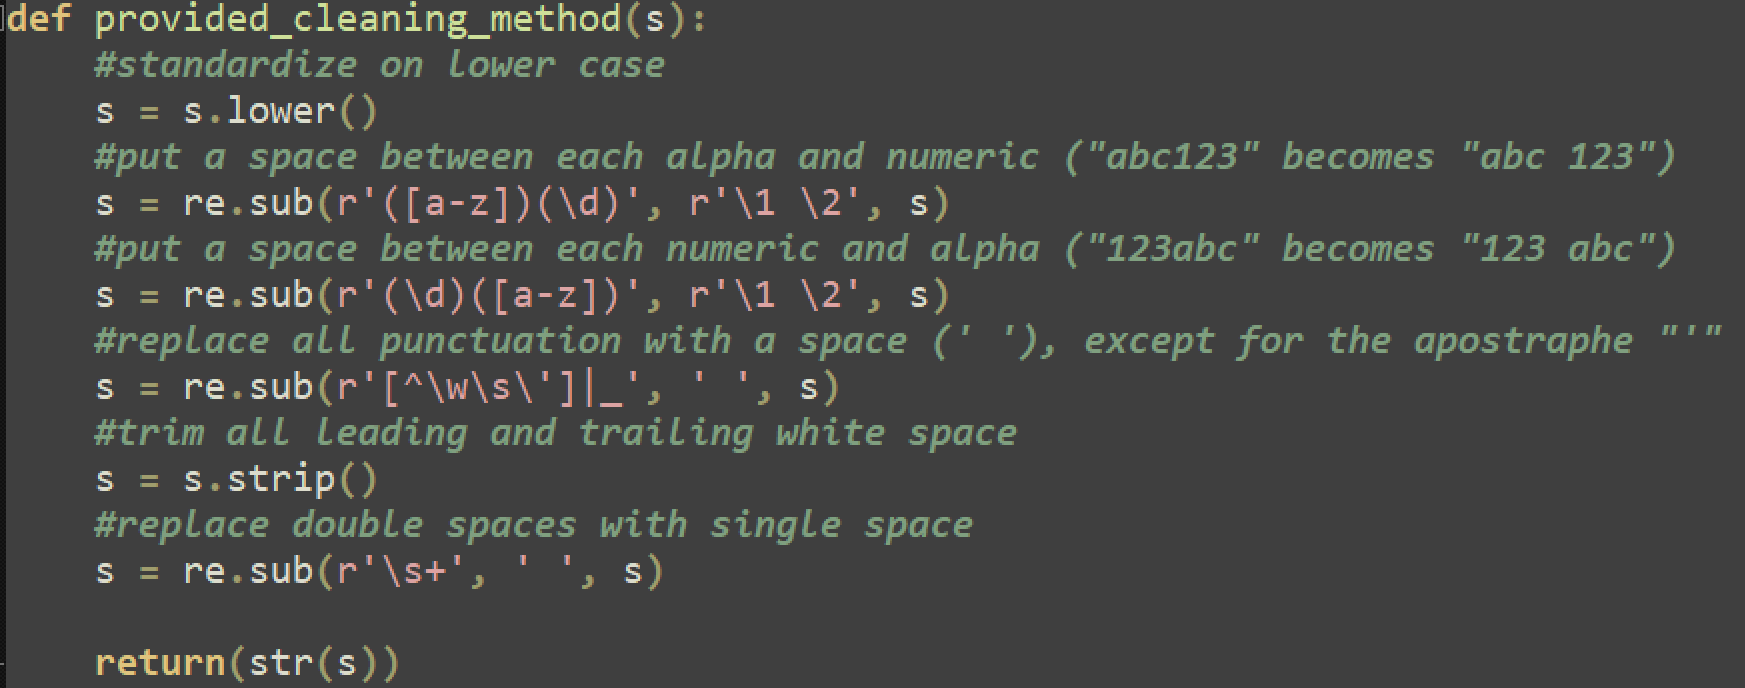